# Laboratorio 3
### Majo Gil 20337
### Joshua Chicoj 20566

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA

In [2]:
dateparse = lambda dates: pd.to_datetime(dates, format='%Y-%m')
data_precios = pd.read_excel('./data/PreciosCombustible.xlsx', parse_dates=['MES/AÑO'], date_parser=dateparse)
data_precios.set_index('MES/AÑO', inplace=True)

C:\Users\PC\AppData\Local\Temp\ipykernel_13380\4255013999.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data_precios = pd.read_excel('./data/PreciosCombustible.xlsx', parse_dates=['MES/AÑO'], date_parser=dateparse)


In [3]:
data_precios.head()

,GASOLINA SUPERIOR,GASOLINA REGULAR,ACEITE COMBUSTIBLE DIÉSEL
MES/AÑO,,,
2002-07-01,14.86,14.52,9.88
2002-08-01,15.68,15.29,10.28
2002-09-01,15.63,15.21,10.24
2002-10-01,16.00,15.57,10.56
2002-11-01,16.12,15.69,16.45


In [4]:
train_size = int(len(data_precios) * 0.6)
val_size = int(len(data_precios) * 0.8)

train_data = data_precios[0:train_size]['GASOLINA SUPERIOR']
val_data = data_precios[train_size:val_size]['GASOLINA SUPERIOR']
test_data = data_precios[val_size:len(data_precios)]['GASOLINA SUPERIOR']

In [5]:
train_size, val_size

(157, 210)

## Modelo anterior

### Visualización del modelo

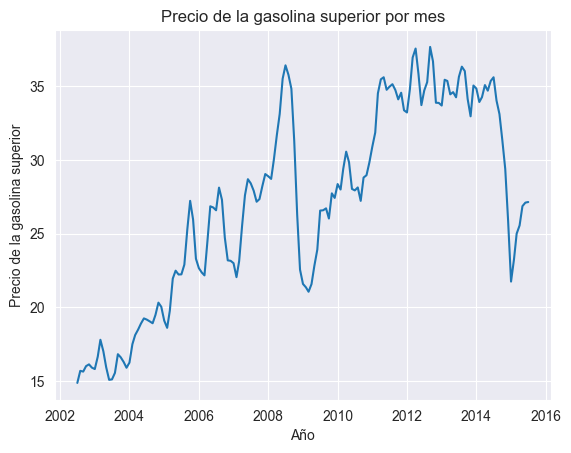

In [6]:
plt.plot(train_data)
plt.gca().set(title="Precio de la gasolina superior por mes", xlabel="Año", ylabel="Precio de la gasolina superior")
plt.show()

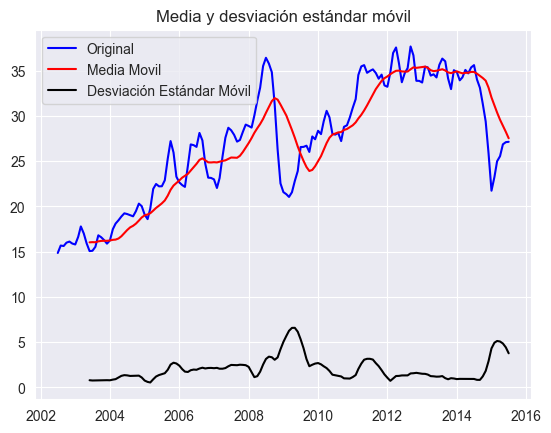

In [7]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = train_data.rolling(window=12).mean()
deMovil = train_data.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(train_data, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

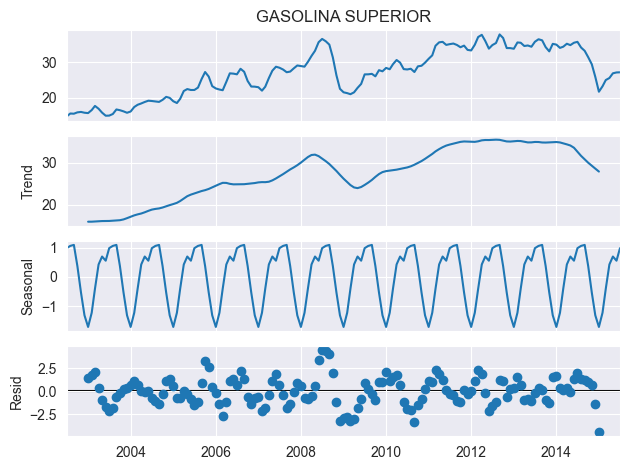

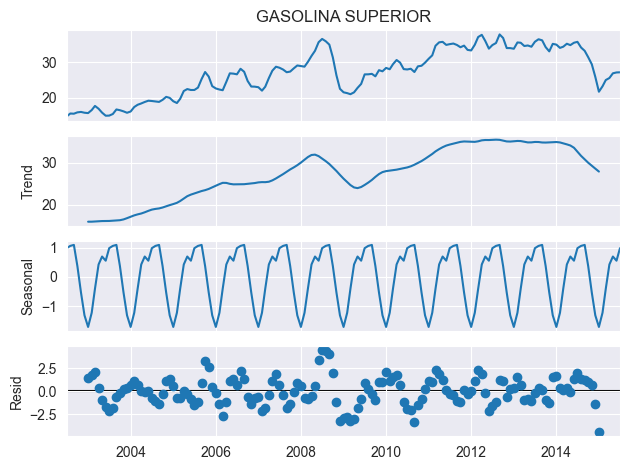

In [8]:
descomposicion = seasonal_decompose(train_data)
descomposicion.plot()

Analizando la tendencia de la serie de tiempo en la gráfica anterior, se tienen indicios de no estacionariedad en la media

### Prueba de Dickey-Fuller

In [9]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(train_data, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -2.187994
p-value                        0.210632
# de retardos usados           2.000000
# de observaciones usadas    154.000000
Critical Value (1%)           -3.473543
Critical Value (5%)           -2.880498
Critical Value (10%)          -2.576878
dtype: float64


Dado que $ \text{valor-p} = 0.211 > 0.05 $ no podemos rechazar la hipótesis nula, esto quiere decir que la media no es estacionaria.

In [10]:
train_data_diff = train_data.diff()
train_data_diff.dropna(inplace=True)

print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(train_data_diff, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba       -7.995871e+00
p-value                      2.405214e-12
# de retardos usados         1.000000e+00
# de observaciones usadas    1.540000e+02
Critical Value (1%)         -3.473543e+00
Critical Value (5%)         -2.880498e+00
Critical Value (10%)        -2.576878e+00
dtype: float64


Después de haber realizado una diferenciación, dado que $ \text{valor-p} = 2.4 \times 10^{-12} < 0.05 $ se rechaza la hipótesis nula, lo cual sugiere que la media es estacionaria.

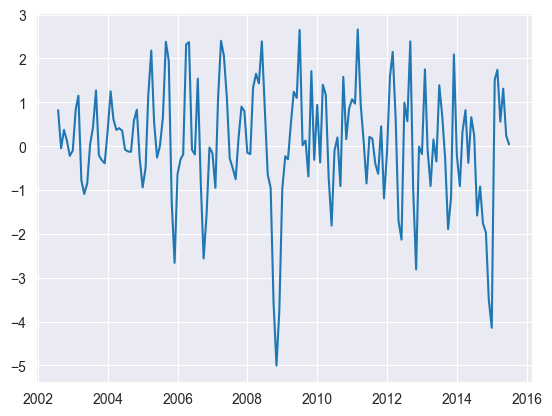

In [11]:
plt.plot(train_data_diff)

### Funciones de autocorrelación
#### ACF

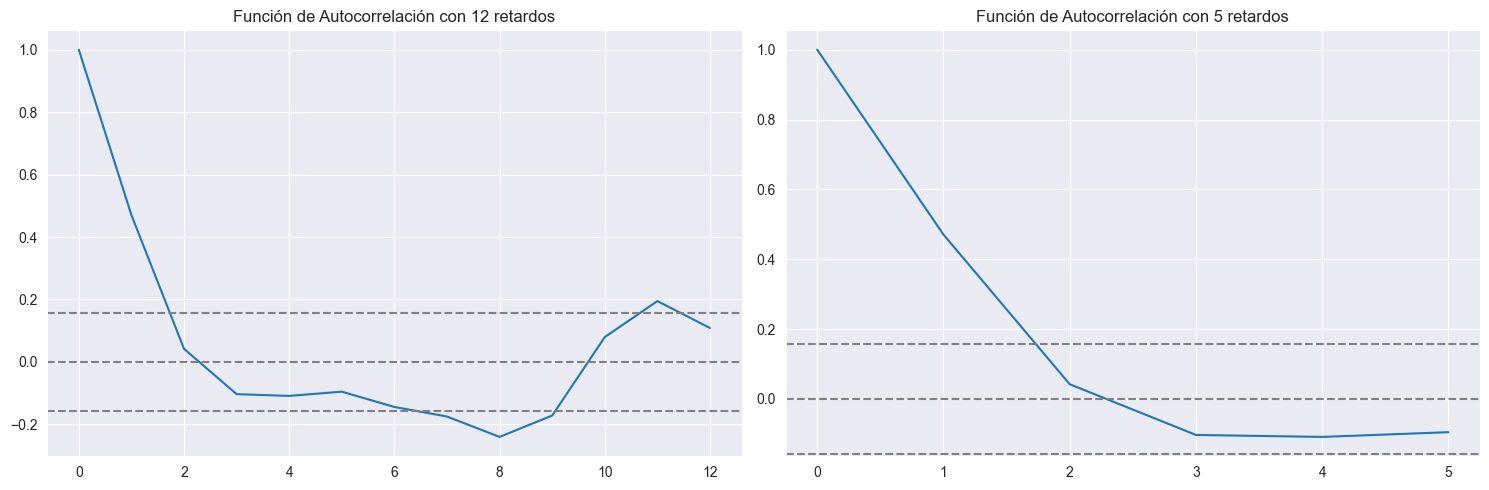

In [12]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF:
plt.subplot(121)
plt.plot(acf(train_data_diff,nlags=12,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_data_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_data_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 retardos')

plt.subplot(122)
plt.plot(acf(train_data_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_data_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_data_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()

#### PACF

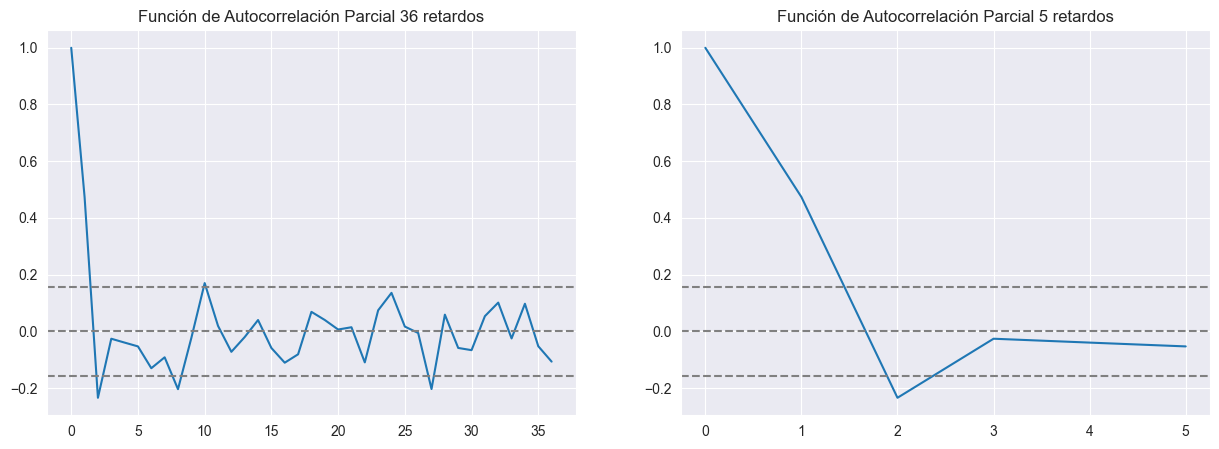

In [13]:
plt.tight_layout()
#plot PACF
plt.subplot(121)
plt.plot(pacf(train_data_diff, nlags=36))
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96 / np.sqrt(len(train_data_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96 / np.sqrt(len(train_data_diff)), linestyle='--', color='gray')
plt.title('Función de Autocorrelación Parcial 36 retardos')

plt.subplot(122)
plt.plot(pacf(train_data_diff, nlags=5))
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96 / np.sqrt(len(train_data_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96 / np.sqrt(len(train_data_diff)), linestyle='--', color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100  # 200 e.g. is really fine, but slower

Como se ve en los gráficos de las funciones de autocorrelación y autocorrelación parcial, podemos intuir que se trata de un modelo teórico similar a un ARMA.
Podíamos probar varios modelos ARIMA:
- p=1, q=1
- p=2, q=1
  
En ambos casos solo es necesaria una diferenciación por lo que d=1

### Estacionalidad

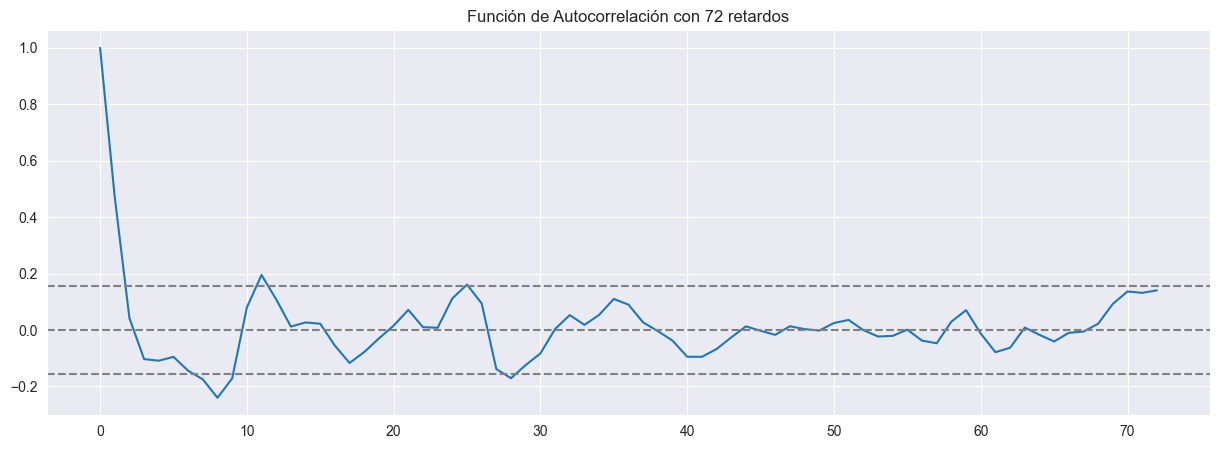

In [14]:
plt.plot(acf(train_data_diff,nlags=72,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_data_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_data_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 72 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

La gráfica anterior sugiera la inexistencia de estacionalidad en los precios de la gasolina superior

### Modelos
#### Modelo 1

C:\Users\PC\PycharmProjects\Labs_DS\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\PycharmProjects\Labs_DS\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\PycharmProjects\Labs_DS\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:      GASOLINA SUPERIOR   No. Observations:                  210
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -316.600
Date:                Thu, 08 Aug 2024   AIC                            641.201
Time:                        20:24:04   BIC                            654.570
Sample:                    07-01-2002   HQIC                           646.606
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2039      0.137      8.816      0.000       0.936       1.472
ar.L2         -0.4700      0.064     -7.299      0.000      -0.596      -0.344
ma.L1         -0.7279      0.152     -4.783      0.0

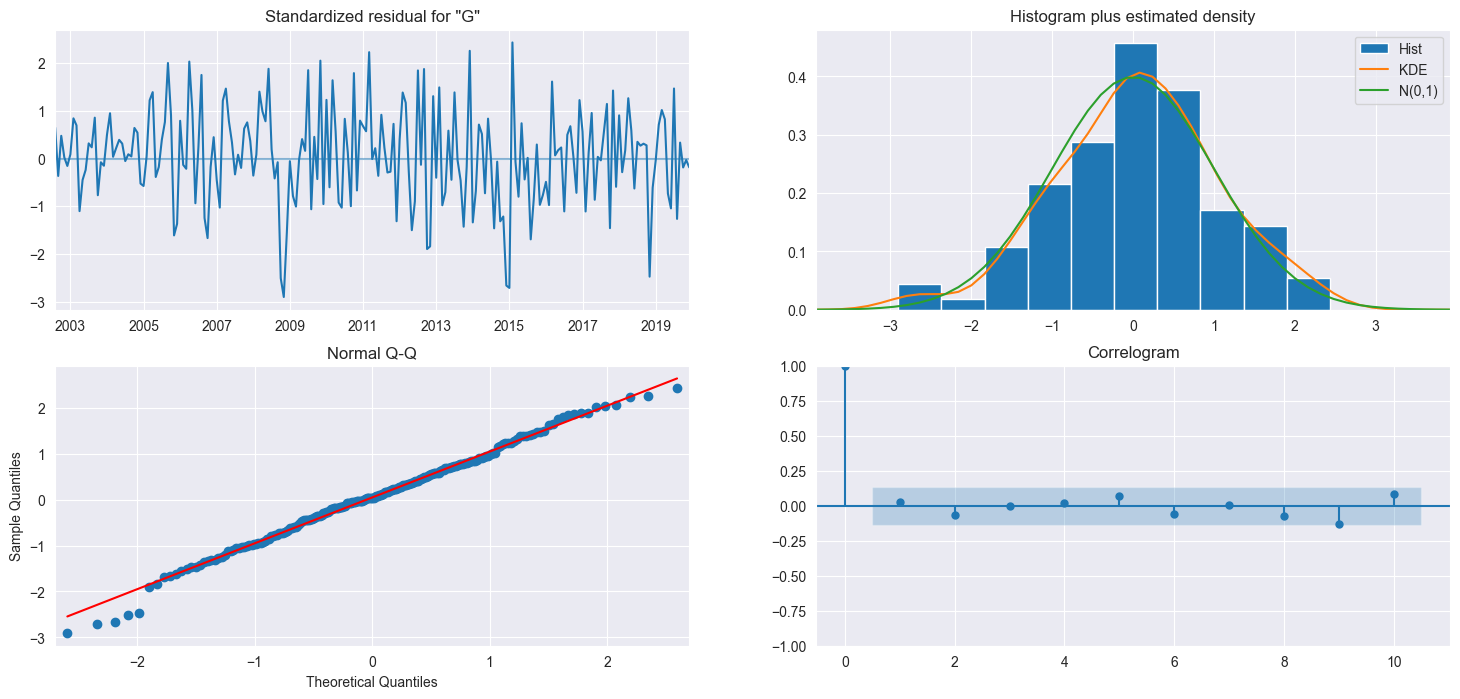

In [15]:
model_211 = ARIMA(pd.concat([train_data, val_data]), order=(2, 1, 1))
model_fit_211 = model_211.fit()

print(model_fit_211.summary())

model_fit_211.plot_diagnostics(figsize=(18, 8))
plt.show()

RMSE: 8.106150971148518


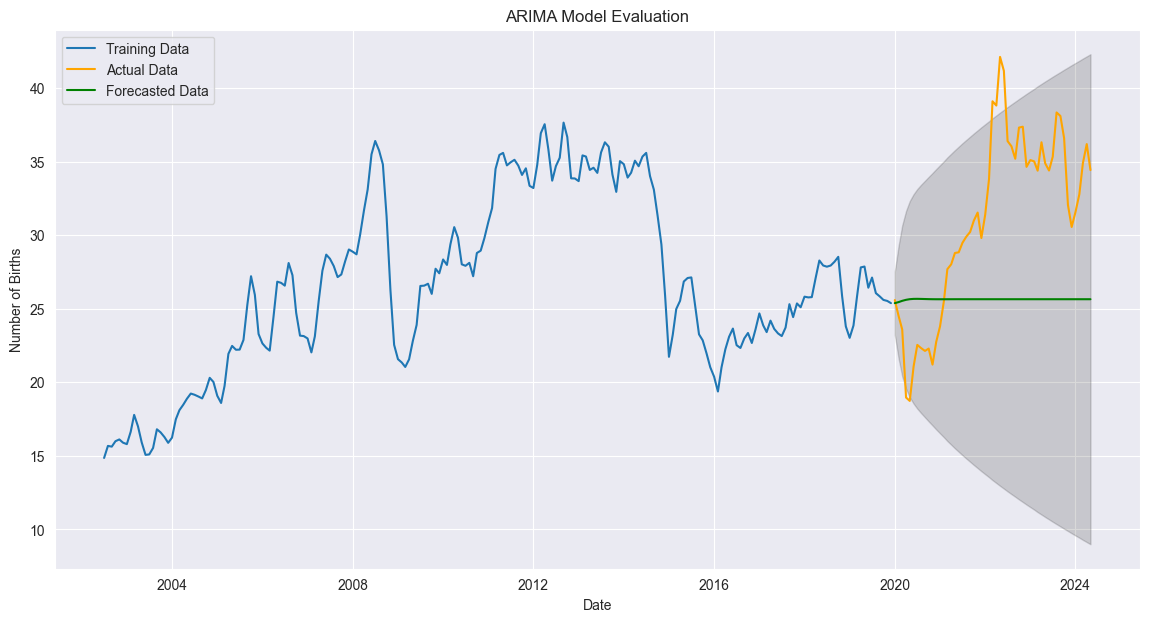

In [16]:
from sklearn.metrics import mean_squared_error

# Forecast on the test dataset
test_forecast = model_fit_211.get_forecast(steps=len(test_data))
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test_data.index)

# Calculate the mean squared error
mse = mean_squared_error(test_data, test_forecast_series)
rmse = mse**0.5

print('RMSE:', rmse)

# Create a plot to compare the forecast with the actual test data
plt.figure(figsize=(14,7))
plt.plot(pd.concat([train_data, val_data]), label='Training Data')
plt.plot(test_data, label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.fill_between(test_data.index, 
                 test_forecast.conf_int().iloc[:, 0], 
                 test_forecast.conf_int().iloc[:, 1], 
                 color='k', alpha=.15)
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.legend()
plt.show()


#### Modelo 2

C:\Users\PC\PycharmProjects\Labs_DS\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\PycharmProjects\Labs_DS\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\PC\PycharmProjects\Labs_DS\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:      GASOLINA SUPERIOR   No. Observations:                  210
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -319.037
Date:                Thu, 08 Aug 2024   AIC                            644.074
Time:                        20:24:05   BIC                            654.101
Sample:                    07-01-2002   HQIC                           648.128
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1835      0.120      1.529      0.126      -0.052       0.419
ma.L1          0.3440      0.128      2.686      0.007       0.093       0.595
sigma2         1.2383      0.116     10.702      0.0

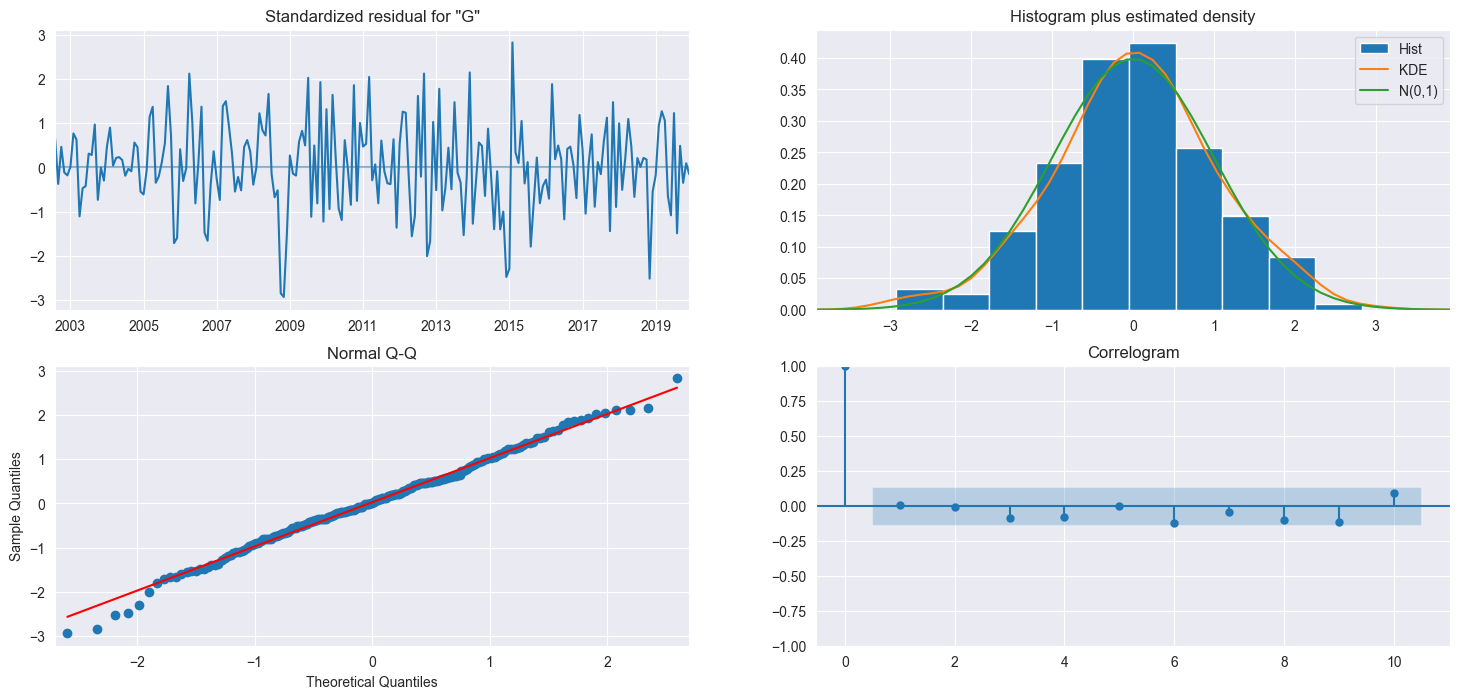

In [17]:
model_111 = ARIMA(pd.concat([train_data, val_data]), order=(1, 1, 1))
model_fit_111 = model_111.fit()

print(model_fit_111.summary())

model_fit_111.plot_diagnostics(figsize=(18, 8))
plt.show()

RMSE: 8.359932655264835


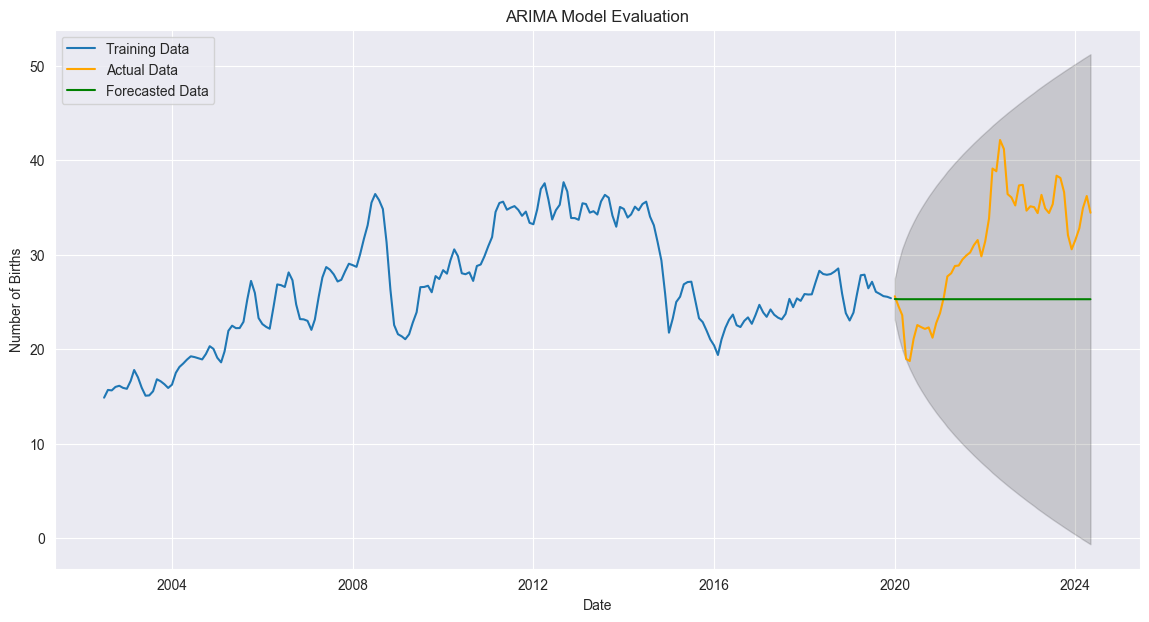

In [18]:
# Forecast on the test dataset
test_forecast = model_fit_111.get_forecast(steps=len(test_data))
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test_data.index)

# Calculate the mean squared error
mse = mean_squared_error(test_data, test_forecast_series)
rmse = mse**0.5

print('RMSE:', rmse)

# Create a plot to compare the forecast with the actual test data
plt.figure(figsize=(14,7))
plt.plot(pd.concat([train_data, val_data]), label='Training Data')
plt.plot(test_data, label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.fill_between(test_data.index, 
                 test_forecast.conf_int().iloc[:, 0], 
                 test_forecast.conf_int().iloc[:, 1], 
                 color='k', alpha=.15)
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.legend()
plt.show()

## Modelos LSTM

In [37]:
from sklearn.preprocessing import StandardScaler

data_diff = data_precios.diff()
data_diff = data_diff.dropna()
data_diff.head()

,GASOLINA SUPERIOR,GASOLINA REGULAR,ACEITE COMBUSTIBLE DIÉSEL
MES/AÑO,,,
2002-08-01,0.82,0.77,0.40
2002-09-01,-0.05,-0.08,-0.04
2002-10-01,0.37,0.36,0.32
2002-11-01,0.12,0.12,5.89
2002-12-01,-0.22,-0.23,-5.89


In [38]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_diff[['GASOLINA SUPERIOR']])

In [40]:
train_scaled = data_scaled[0:train_size]
val_scaled = data_scaled[train_size:val_size]
test_scaled = data_scaled[val_size:len(data_scaled)]

In [41]:
def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

x_train,y_train = supervisada(train_scaled)
x_val,y_val = supervisada(val_scaled)
x_test,y_test = supervisada(test_scaled)

In [42]:
x_train = np.reshape(x_train,(x_train.shape[0],1,1))
x_val = np.reshape(x_val, (x_val.shape[0],1,1))
x_test = np.reshape(x_test, (x_test.shape[0],1,1))

In [43]:
from tensorflow import keras

lote = 1
unidades =  1
paso = 1
caracteristicas = 1 #es univariada

inputs = keras.layers.Input((paso,caracteristicas))
lstm_out = keras.layers.LSTM(lote)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

modelo1 = keras.Model(inputs=inputs, outputs=outputs)
modelo1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14 (56.00 B)

 Trainable params: 14 (56.00 B)

 Non-trainable params: 0 (0.00 B)

In [45]:
modelo1.compile(loss='mean_squared_error',optimizer='adam', metrics=['root_mean_squared_error'], run_eagerly=True)

In [46]:
epocas = 150
history= modelo1.fit(
    x = x_train,
    y = y_train,
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    validation_data = (x_val,y_val),
    #callbacks=[early_stop],
    verbose=1
)

Epoch 1/150
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.6526 - root_mean_squared_error: 0.7766 - val_loss: 0.4704 - val_root_mean_squared_error: 0.6859
Epoch 2/150
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.6462 - root_mean_squared_error: 0.7728 - val_loss: 0.4680 - val_root_mean_squared_error: 0.6841
Epoch 3/150
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.6418 - root_mean_squared_error: 0.7703 - val_loss: 0.4661 - val_root_mean_squared_error: 0.6827
Epoch 4/150
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.6384 - root_mean_squared_error: 0.7684 - val_loss: 0.4647 - val_root_mean_squared_error: 0.6817
Epoch 5/150
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.6355 - root_mean_squared_error: 0.7668 - val_loss: 0.4635 - val_root_mean_squared_error: 0.6808
Epoch 6/150
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.6332 - root_mean_squared_error: 0.7655 - val_loss: 0.4626 - val_root_mean_squared_error: 0.6802
Epoch 7/150
156/156 ━━━━━━━━━━━━━━━━━━━━

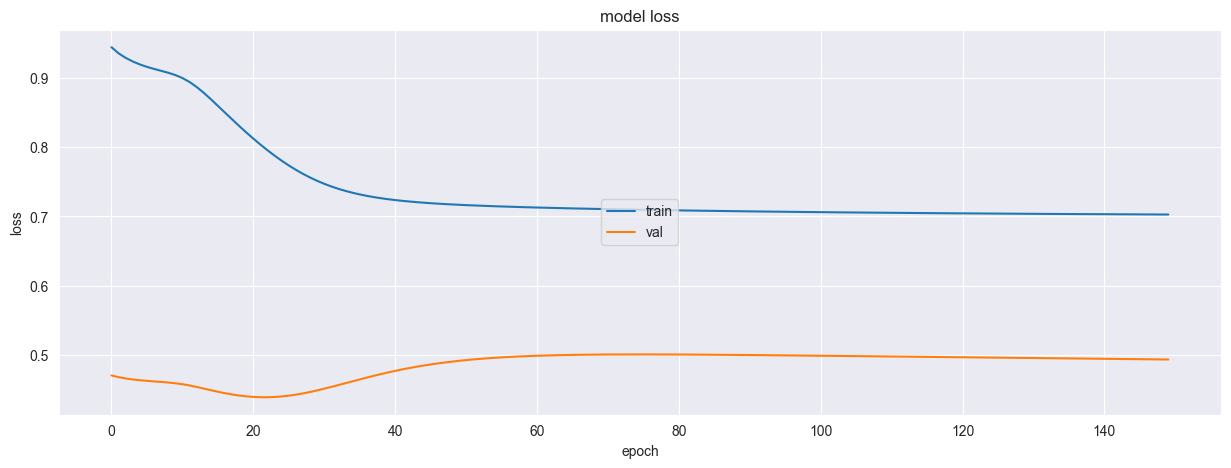

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='center')

<Axes: >

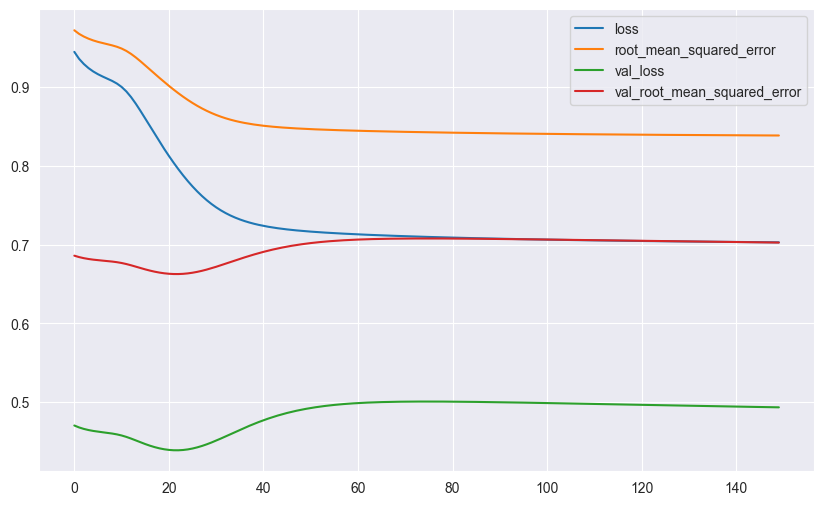

In [48]:
losses_df1 = pd.DataFrame(history.history)

losses_df1.plot(figsize = (10,6))

In [49]:
print("Pérdida en Entrenamiento")
modelo1.evaluate(
    x = x_train,
    y = y_train
)
print("Pérdida en Validación")
modelo1.evaluate(
    x = x_val,
    y = y_val
)
print("Pérdida en Prueba")
modelo1.evaluate(
    x = x_test,
    y = y_test
)

Pérdida en Entrenamiento
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5500 - root_mean_squared_error: 0.7297 
Pérdida en Validación
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4679 - root_mean_squared_error: 0.6835 
Pérdida en Prueba
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7531 - root_mean_squared_error: 1.3240 


[1.7210066318511963, 1.3118714094161987]

In [62]:
def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion

prediccion_val = prediccion_fun(x_val,modelo1, 1,scaler,dif=True,dif_cant=1, Series = data_precios['GASOLINA SUPERIOR'].values , n=train_size)
prediccion_test = prediccion_fun(x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = data_precios['GASOLINA SUPERIOR'].values , n=val_size)


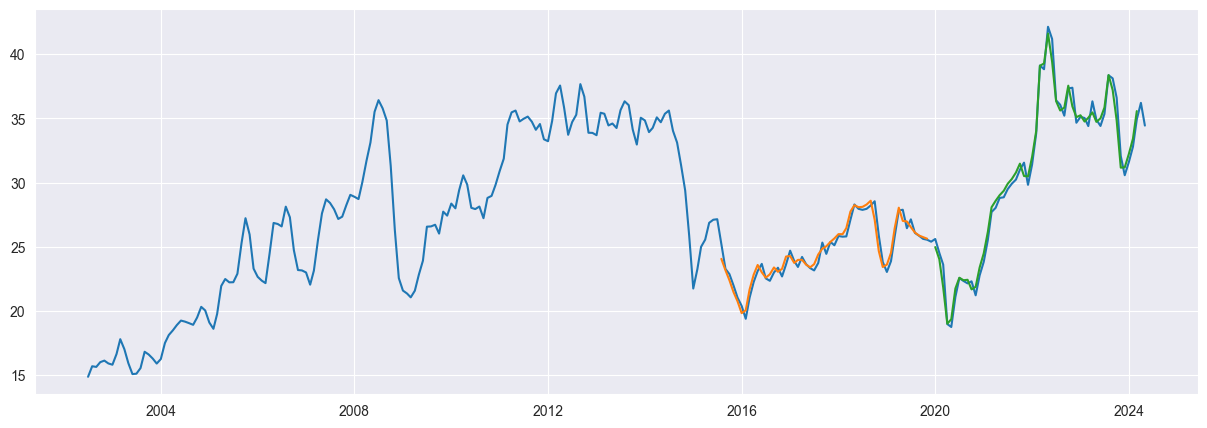

In [66]:
df_val = pd.DataFrame(prediccion_val, index=(data_precios['GASOLINA SUPERIOR'])[train_size:val_size - 1].index)
df_test = pd.DataFrame(prediccion_test,index=(data_precios['GASOLINA SUPERIOR'])[val_size:len((data_precios['GASOLINA SUPERIOR'])) -2].index)


plt.plot(data_precios['GASOLINA SUPERIOR'])
plt.plot(df_val)
plt.plot(df_test)